In [ ]:
"""
This is an optimal but heavy weighted solution to the problem.
This complex neural network should only be applied to raw data.

This solution, being a complex yet accurate and optimized solution, is to benchmark the performance of the better solution introduced in MA_LSTM.ipy
"""

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import datetime as dt
import copy
from matplotlib import pyplot

import numpy as np
import pandas as pd
from time import time as T

from math import sqrt
#from numpy import concatenate
from matplotlib import pyplot
#from pandas import read_csv
#from pandas import DataFrame
#from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

Using TensorFlow backend.


In [2]:
headers = ['Unnamed: 0', 'seconds_passed','second','minute','hour','day_of_week','day_of_month','month','season','year','VM_load','requests_per_second','disk_usage']
usecols = copy.deepcopy(headers)
usecols.remove('seconds_passed')
usecols.remove('requests_per_second')
usecols.remove('disk_usage')
usecols.remove('second')
usecols.remove('minute')
usecols.remove('year')
# load data
def parse_date_time(x):
    return dt.datetime.strptime(x, '%Y %m %d %H %M %S')
dataset = pd.read_csv('data.csv', usecols=usecols, index_col=0)
dataset.index.name = 'index'
#dataset.drop('Unnamed: 0', axis=1, inplace=True)
# dataset.drop('seconds_passed', axis=1, inplace=True)
# dataset.drop('second', axis=1, inplace=True)
# dataset.drop('minute', axis=1, inplace=True)
dataset = dataset[['hour', 'VM_load', 'day_of_month', 'month', 'season', 'day_of_week']]
dataset.head()

/home/mammalofski/.virtualenvs/final_project/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,hour,VM_load,day_of_month,month,season,day_of_week
index,,,,,,
0,0,1.046394,1,1,0,1
1,0,1.037863,1,1,0,1
2,0,1.043727,1,1,0,1
3,0,1.086876,1,1,0,1
4,0,1.109945,1,1,0,1


In [3]:
MA_dataset = pd.read_csv('MV.csv', index_col=0)

In [4]:
MA_dataset.head()

,moving_average,lower_bound,higher_bound
0,0.928326,0.687118,1.391741
1,0.928813,0.687345,1.392126
2,0.929545,0.687573,1.392511
3,0.930487,0.687800,1.392895
4,0.931383,0.688027,1.393280


In [5]:
dataset = dataset[:2072100]
print(len(dataset))
print(len(MA_dataset))

2072100
2072100


In [6]:
dataset['VM_load'] = MA_dataset['higher_bound']

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 


In [8]:
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

In [9]:

# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_steps = 3 
n_features = 5
# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps, 1)
print(reframed.shape)

(2072097, 24)


In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = int(0.8 * values.shape[0])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1657677, 15) 1657677 (1657677,)
(1657677, 3, 5) (1657677,) (414420, 3, 5) (414420,)


In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1657677, 3, 5) (1657677,) (414420, 3, 5) (414420,)


In [20]:
def model(mode):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True),
                            input_shape=(train_X.shape[1], train_X.shape[2]), 
                            merge_mode=mode))
    model.add(RepeatVector(train_X.shape[2]))
    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True),
                            input_shape=(train_X.shape[1], train_X.shape[2]), 
                            merge_mode=mode))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

model = model('sum')

In [21]:
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1657677 samples, validate on 414420 samples
Epoch 1/10
 - 211s - loss: 0.0011 - val_loss: 0.0412
Epoch 2/10
 - 215s - loss: 1.2379e-04 - val_loss: 0.0129
Epoch 3/10
 - 199s - loss: 1.3542e-04 - val_loss: 0.0026
Epoch 4/10
 - 213s - loss: 1.0627e-04 - val_loss: 0.0026
Epoch 5/10
 - 211s - loss: 7.8380e-05 - val_loss: 0.0023
Epoch 6/10
 - 209s - loss: 6.3909e-05 - val_loss: 8.7686e-04
Epoch 7/10
 - 209s - loss: 5.8324e-05 - val_loss: 0.0017
Epoch 8/10
 - 218s - loss: 4.8456e-05 - val_loss: 7.5029e-04
Epoch 9/10
 - 211s - loss: 4.1561e-05 - val_loss: 0.0024
Epoch 10/10
 - 212s - loss: 4.3148e-05 - val_loss: 0.0024


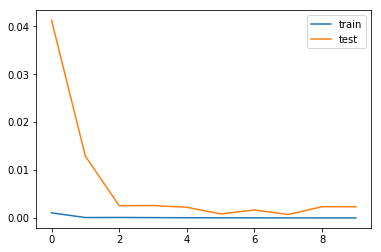

In [22]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_steps*n_features))

In [24]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [25]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.120


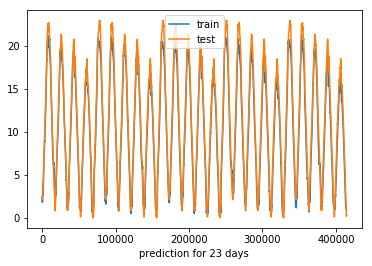

In [26]:
pyplot.plot(inv_yhat, label='train')
pyplot.plot(inv_y, label='test')
pyplot.xlabel('prediction for 23 days')
pyplot.legend()
#pyplot.savefig('23days.eps', format='eps')
pyplot.show()

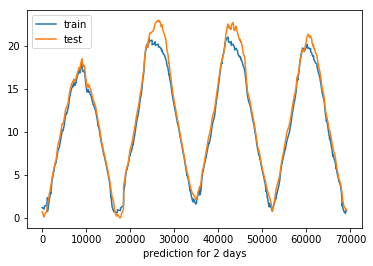

In [28]:
day = int(24 * 3600 /5)
pyplot.plot(inv_yhat[3*day:7*day], label='train')
pyplot.plot(inv_y[3*day:7*day], label='test')
pyplot.xlabel('prediction for 2 days')
pyplot.legend()
#pyplot.savefig('5000sec.eps', format='eps')
pyplot.show()